In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from iqx import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
from qiskit.providers.aer.noise import NoiseModel, pauli_error
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit.quantum_info import Operator
from qiskit import QuantumRegister, ClassicalRegister

# <span style="color:red">**TASK 2**</span>$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\sqrthalf}{\dfrac{1}{\sqrt{2}}}$

## <span style="color:blue">1) Creating **simple Bell circuit** _without_ any error gate</span>
The given circuit in Task 2 creates a bell pair with the statevector, $\ket{\Phi^+} = \sqrthalf\ket{00} + \sqrthalf\ket{11}$.<br>
Because, <br>$\begin{align}CX_{12}\left(H\otimes I\right)\ket{00} &= CX_{12}\ket{+0} \\
&= CX_{12}\left(\sqrthalf\big(\ket{0} + \ket{1}\big)\otimes\ket{0}\right)\\
&= \sqrthalf CX_{12}\big(\ket{00} + \ket{10}\big)\\
&= \sqrthalf\ket{00} + \sqrthalf\ket{11}\\
&= \ket{\Phi^+}
\end{align}$

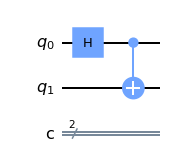

In [3]:
# creating the given circuit
simple_bell_circ = QuantumCircuit(2,2)
simple_bell_circ.h(0)
simple_bell_circ.cx(0,1)
simple_bell_circ.draw()

## <span style="color:blue">2) Creating a *bit-phase-filp* **error gate**</span>

Just like classical computation, we have to deal with bit-flip errors in quantum computing.<br>
This type of error turns $\ket{0}$ into $\ket{1}$ and vice versa. In other words, $X$ gate gets randomly applied on a  qubit with some probability $p$.<br>
For simulating bit-flip error, I am making a new gate "$\mathcal{E}$" which is basically an identity gate, but noise model will be induced on this specific gate.<br>
So the Kraus operators for bit-flip will be: $E_1 = \sqrt{1-p}I$ and $E_2 = \sqrt{p}X$
This means, the Superoperator will be:
$$\mathcal{E}_{bit}(\rho) = \sum_{k=1}^{2} E_k \rho E_k^{\dagger} = (1-p)\,\rho + p\,X\rho X$$

This is not the only type of error in quantum computer though. Since the idea of phase deosn't exist in classical computing, we are introduced to a new type of error called phase-flip error. It randomly applies a $Z$ gate on a qubit with some probability $p$ where $p<0.5$.<br>
On compuational basis, this error just introduces a global phase. But it's effect is dramatic on other bases. For example, this error can turn $\ket{+}$ into $\ket{-}$ and vice versa. Kraus operators for this error are: $E_1 = \sqrt{1-p}I$ and $E_2 = \sqrt{p}Z$<br>
And the Superoperator will be:
$$\mathcal{E}_{phase}(\rho) = \sum_{k=1}^{2} E_k \rho E_k^{\dagger} = (1-p)\,\rho + p\,Z\rho Z$$

If both of these errors can occur (with the same probability $p$), the error can be described using the Superoperator:
$$\begin{align}
\mathcal{E}_{bit-phase}(\rho) &= \mathcal{E}_{phase}(\mathcal{E}_{bit}(\rho))\\
&= (1-p)^2\,\rho + p(1-p)\,X\rho X + p(1-p)\,Z\rho Z + p^2\,ZX\rho XZ\\
&= (1-p)^2\,\rho + p(1-p)\,X\rho X + p(1-p)\,Z\rho Z + p^2\,Y\rho Y
\end{align}$$

For this exercise, I'm taking $p=0.1$. Which will give us, $$\mathcal{E}_{bit-phase}(\rho) = 0.81\,\rho + 0.09\,X \rho X + 0.09\,Z\rho Z + 0.01\,Y \rho Y$$

In [4]:
# p = probability of occuring error
# bit and phase flip error on 1 qubit
bit_flip = lambda p: pauli_error([('X', p), ('I', 1-p) ])
phase_flip = lambda p: pauli_error([('Z', p), ('I', 1-p) ])
bit_phase_flip = lambda p: bit_flip(p).compose(phase_flip(p))
# print example error probabilities
print(bit_phase_flip(0.05))

# create an error gate E using an identity gate
E = Operator([[1,0],[0,1]])

# function to create noise model with specified error
def get_noise_model(error):
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, '$\mathcal{E}$')
    # adding 'unitary' as a basis gate to prevent transpiler from unrolling it
    noise_model.add_basis_gates(['unitary'])
    return noise_model

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}]
  P(1) = 0.0475, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(2) = 0.0475, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.9025, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


### Recreating the same bell state preparing circuit with error gate applied before CX gate

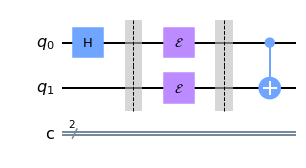

In [5]:
# creating bell circuit with error gate before CX gate
err_bell_circ = QuantumCircuit(2,2)
err_bell_circ.h(0)
err_bell_circ.barrier()
# introducing error gate
err_bell_circ.unitary(E, err_bell_circ.qubits, label='$\mathcal{E}$')
err_bell_circ.barrier()
# rest of the circuit
err_bell_circ.cx(0,1)
err_bell_circ.draw()

## <span style="color:blue">3) **Encoding** qubits to *detect* and *fix* the errors</span>
### **Only Bit-Flip Error:**
Starting simple, let's look at only bit-flip error on a single qubit first. If the probability of occurring bit-flip error is less than 50% (i.e. $p<0.5$), we can use simple 3 bits **repetition code** to detect and fix the error. So, we can encode $\ket{0}$ using 3 qubits with the state $\ket{0}_L \equiv \ket{000}$ and encode $\ket{1}$ using $\ket{1}_L \equiv \ket{111}$.<br>
### **Justification of Encoding Scheme:**
Now it might be tempting to think that we can encode any arbitrary state $\ket{\Psi} = \alpha\ket{0} + \beta\ket{1}$ using the same technique, $\ket{\Psi}\otimes\ket{\Psi}\otimes\ket{\Psi}$. But this is **NOT** possible due to **No Cloning theorem**.<br><br>
There is a solution though. Ifnstead of encoding $\ket{\Psi}$ into the whole 3 qubit space, we can encode it into the $\big\{\ket{000},\ket{111}\big\}$ **subspace**. So, we can encode $\ket{\Psi} = \alpha\ket{0} + \beta\ket{1}$ into:
$$\ket{\Psi}_L =\alpha\ket{0}_L + \beta\ket{1}_L = \alpha\ket{000} + \beta\ket{111}$$ <br>

Now let's take a look at how this encoding can protect against bit-flip errors. Since we have 3 qubits here, one of these 8 possible errors will occur: $\big\{III,XII,IXI,IIX,XXI,XIX,IXX,XXX\big\}$ <span style="font-size:8pt">[note: I have dropped $\otimes$ for notational convenience. $IXI$ here stands for $I\otimes X\otimes I$]</span><br><br>

Since we are using repetition code, we can correct only if **at most 1 qubit** gets flipped. That's why it's important for $p$ to be less than 50%. So out of all the possible errors, we can only fix these situations: $\big\{III,XII,IXI,IIX\big\}$. The effects of each of these errors are summarized:

| Error Operation | Effect of Error on Encoded Subspace |
| :-: | :-: |
| $III$ | $\ket{000} \rightarrow \ket{000}\\ \ket{111} \rightarrow \ket{111}$ |
| $XII$ | $\ket{000} \rightarrow \ket{100}\\ \ket{111} \rightarrow \ket{011}$ |
| $IXI$ | $\ket{000} \rightarrow \ket{010}\\ \ket{111} \rightarrow \ket{101}$ |
| $IIX$ | $\ket{000} \rightarrow \ket{001}\\ \ket{111} \rightarrow \ket{110}$ |

As we can see from the table, the **error subspaces are orthogonal** to each other. Also within a subspace the states remains (it's obvious since the errors are unitary operation). Thits means, all of these errors can be separately detected and corrected. But before we do that, we need a circuit to encode our qubit.

### **Enocding Circuit:**
In order to create $\ket{0} \rightarrow \ket{000}$ and $\ket{1} \rightarrow \ket{111}$, we can just use $CX$ gate. So, if we are given a qubit with arbitrary state $\ket{\Psi} = \alpha\ket{0} + \beta\ket{1}$, we can use $CX$ gate on 2 ancillary qubits to achieve the encoded format:
$$\begin{align}
\ket{\Psi}\otimes\ket{00} &\rightarrow CX_{13}CX_{12} \big(\ket{\Psi}\otimes\ket{00}\big)\\
&= CX_{13}CX_{12} \bigg(\big(\alpha\ket{0} + \beta\ket{1}\big)\otimes\ket{00}\bigg)\\
&= CX_{13}CX_{12} \big(\alpha\ket{000} + \beta\ket{100}\big)\\
&= CX_{13} \big(\alpha\ket{000} + \beta\ket{110}\big)\\
&= \alpha\ket{000} + \beta\ket{111}\\
&= \ket{\Psi}_L
\end{align}
$$<br>
So the encoding circuit for bit-flip error will be:
<img src="https://raw.githubusercontent.com/shawon265/QOSF-cohort-3/main/images/encode_bit_flip.png">

### **Deocding Circuit:**
Now that we have successfully encoded any arbitrary state, we need a circuit to detect the errors and fix them correspondingly.For this, we can again use $CX$ gates.<br>
We can interpret $CX$ gate as equivalent to classical **XOR** gate on qubits. It can be shown that, if $a,b \in \big\{ 0,1\big\}$, then $CX_{12}\ket{a}\ket{b} =\ket{a}\ket{a\oplus b}$.
<img src="https://i.stack.imgur.com/VMPhw.png" width="25%">
Why do we care about XOR operation? It's becasue by definition it outputs $0$ if $a=b$ and outputs $1$ if $a\neq b$. So XOR operation can be used for checking mismatch between 2 bits. That means if we apply $CX$ and get $\ket{1}$, control and target qubit data doesn't match with each other indicating one of the qubits has been flipped. How do we figure out which of the qubit got flipped? For that we compare another pair. If in both cases we get $\ket{1}$, that means the common qubit has been flipped and we need to flip it back to fix it. Otherwise if we get $\ket{0}$, that will mean the common qubit was not flipped, so don't do anything.<br>
So, to detect the the error, we apply 2 $CX$ gates and compare 2 pairs of qubits. And to fix it we use toffoli gate whose target qubit is the common qubit and controls are rest of the qubits. So the decoding circuit (detection + correction) will be:
<img src="https://raw.githubusercontent.com/shawon265/QOSF-cohort-3/main/images/decode_bit_flip.png">
So the complete circuit for encoding and decoding against bit-flip error would look like this:
<img src="https://github.com/shawon265/QOSF-cohort-3/blob/925c7c0158f890fa5901347900c2cb6c982cbc08/images/encode_decode_bit_flip.png?raw=true">


### **Only Phase-Flip Error:**
We have seen how to protect against bit-flip error. Next we need to deal with phase-flip error. Even though phase-flip error doesn't affect computational basis vectors (just introduces a global phase to $\ket{1}$, it affects every other states. Specially, it's effects can be seen on diagonal basis. It converts $\ket{+}$ into $\ket{-}$ and vice versa.<br>
In fact, phase-flip error acts on diagonal basis vectors just as bit-flip error acts on computational basis.

| Bit-Flip Error | Phase-Flip Error |
| :-: | :-: |
| $\ket{0} \rightarrow \ket{1}\\\ket{1} \rightarrow \ket{0}$ | $\ket{+} \rightarrow \ket{-}\\\ket{-} \rightarrow \ket{+}$ |

Due to this similarity, we can transform diagonal basis into computational basis by applying $H$ gate and then pass it through a bit-flip encoding-decoding scheme and then apply $H$ gate again to transform it back to diagonal basis. Thus we can protect agains phase-flip error. Here's the circuit for encoding and decoding against phase-flip error:
<img src="https://github.com/shawon265/QOSF-cohort-3/blob/main/images/encode_decode_phase_flip.png?raw=true">

In both of these cases, we can show that "Fidelity" for 3 qubit encoding, $F_3 = \sqrt{\text{tr}\left(\rho\mathcal{E}\right)} \geq \sqrt{(1-p)^3 +3p(1-p)^2}$.<br>
For this to have better fidelity than no encoding, we need $F_3 > F_1 \Rightarrow\; F_3 > \sqrt{1-p} \Rightarrow\; p < \dfrac{1}{2}$. This exactly why probability of error occuring must be less than 50%.<br>
All in all, in the bit-flip case, we encoded our qubit onto $\text{span}\big\{\ket{000},\ket{111}\big\}$ subspace. And in the case of phase-flip error, we encoded our qubit onto $\text{span}\big\{\ket{+++},\ket{---}\big\}$ subspace. So, here,
$$\ket{0}_L = \ket{+++}$$
$$\ket{1}_L = \ket{---}$$
### **Bit and Phase-Flip Error:**
Now, how do we correct for both of the errors at the same time? Just like we previously encoded our qubit into 3 qubits, we can do the same to protect against only phase-flip error. Then for each of the 3 qubits, we can employ 3 more qubits to encode bit information. So using 9 qubits in total, we can encode 1 logical qubit:<br>
$$\ket{0}_L =\ket{ppp} = \dfrac{1}{2\sqrt{2}}\big(\ket{000} + \ket{111}\big)\otimes\big(\ket{000} + \ket{111}\big)\otimes\big(\ket{000} + \ket{111}\big)$$
$$\ket{1}_L =\ket{mmm} = \dfrac{1}{2\sqrt{2}}\big(\ket{000} - \ket{111}\big)\otimes\big(\ket{000} - \ket{111}\big)\otimes\big(\ket{000} - \ket{111}\big)$$
where, $\ket{p} = \sqrthalf\big(\ket{000} + \ket{111}\big)$ and $\ket{m} = \sqrthalf\big(\ket{000} - \ket{111}\big)$. Reason behind taking these two states is that a single phase-flip error sends $\ket{p}$ to $\ket{m}$ and vice versa, i.e. it looks like a bit-flip error. To protect against bit flip error as well, we use repetition of these states to encode both enformations $\ket{ppp}$  and $\ket{mmm}$.<br>
This encoding scheme was first discovered by *Peter Shor*. Hence this code is called **Shor code** and it was one of the pioneering works towards realization of quantum computers. For encoding and decoding, we will need to use the bit-flip and phase-flip circuits in conjunction:
<img src="https://github.com/shawon265/QOSF-cohort-3/blob/main/images/encode_decode_bit_phase_flip.png?raw=true">
We can thus see that Shor can correct a lot of codes. In fact, we can figure out all the correctable errors by looking at it's stabilizer generators:

| Symbol | Operator |
| :-: | :-: |
| $S_1$ | $ZZIIIIIII$ |
| $S_2$ | $ZIZIIIIII$ |
| $S_3$ | $IIIZZIIII$ |
| $S_4$ | $IIIZIZIII$ |
| $S_5$ | $IIIIIIZZI$ |
| $S_6$ | $IIIIIIZIZ$ |
| $S_7$ | $XXXXXXIII$ |
| $S_8$ | $XXXIIIXXX$ |

Now since these are the **stabilizer generators**, we can create the **stabilizer group** from them:
$$\langle S_i \rangle = \big\{\prod_{i=1}^{8} S_{i}^{a_i}\;\big|\;  a_i \in \{ 0,1\}\big\}$$
Every element of this set will represent a distinct operator that can be identified and corrected accordingly. So, in total shor code can correct $2^8=256$ distinct types of Puali errors using syndrome detection technique. Although we are only looking for 1 qubit errors. Number of such cases that can arise is $1+3\times9 = 28$.<br>
One added benifit of shor code is that, it can protect against, $Y$-error as well, since $Y=-iZX$ i.e. applying $Y$ gate is equivalent to applying both $X$ and $Z$ gate. So, Shor code can actually protect against **any one qubit Pauli error**. In fact, since any unitary operation can be written as linear combination of Pauli operators, Shor code can protect against **any arbitrary unitary operation** on one of the 9 qubits.<br>


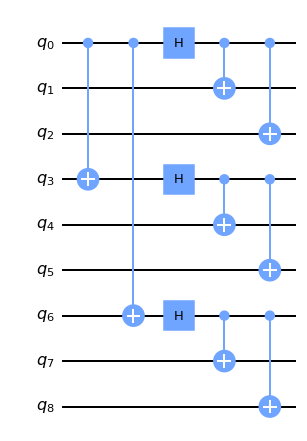

In [6]:
# encoding circuit for shor code
def shor_encode():
    # 9 qubits = 1 logical qubit
    qlog = QuantumRegister(9)
    qc = QuantumCircuit(qlog, name='Shor\nEncode')
    qc.cx(qlog[0:1]*2,qlog[3::3])
    qc.h(qlog[::3])
    qc.cx(qlog[::3],qlog[1::3])
    qc.cx(qlog[::3],qlog[2::3])
    return qc.to_instruction()

shor_encode().definition.draw()

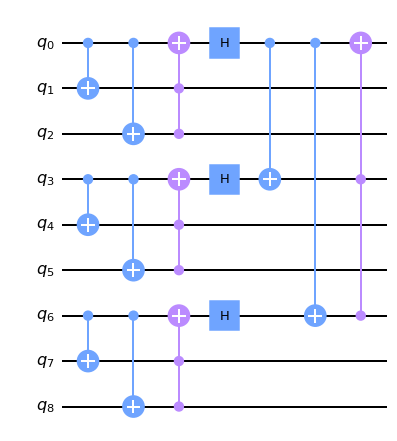

In [7]:
# encoding circuit for shor code
def shor_decode():
    # 9 qubits = 1 logical qubit
    qlog = QuantumRegister(9)
    qc = QuantumCircuit(qlog, name='Shor\nDecode')
    # bit flip
    qc.cx(qlog[::3],qlog[1::3])
    qc.cx(qlog[::3],qlog[2::3])
    qc.ccx(qlog[1::3],qlog[2::3], qlog[::3])
    # phase flip
    qc.h(qlog[::3])
    qc.cx(qlog[0:1]*2,qlog[3::3])
    qc.ccx(qlog[6],qlog[3], qlog[0])
    return qc.to_instruction()

shor_decode().definition.draw()

## <span style="color:blue">4) Measuring in **Bell basis** and comparing results</span>
Since Shor code protects against any arbitrary unitary error on one qubit, the probability of successfully preserving an state will be, $P_{Shor Code} = (1-p)^9 + 9p(1-p)^8$. On the other hand, if no encoding was used, we would have only $P_{No Encoding} = (1-p)^2$. For Shor code to perform better than unencoded qubits, we $P_{Shor Code} > P_{No Encoding}$. From this inequality, it follows that $p$ has an upper-limit: $p<0.0764796$. So, as long as we choose a $p$ lower than this threshold, we can expect Shor code to perform better than unencoded qubits.

In [8]:
# helper function for creating final circuit with measurement
def create_complete_circuit(qc, meas_basis = 'Computational'):
    # add measurement device to one of the above circuits
    qc = qc.copy()
    b = qc.num_qubits//2 # position of 2nd qubit of bell pair
    qc.barrier()
    if meas_basis.lower()[:4] == 'diag':
        qc.h([0,b])
    elif meas_basis.lower()[:4] == 'bell':
        qc.cx(0,b)
        qc.h(0)
    qc.measure([0,b],[0,1])
    return qc, meas_basis

In [9]:
# helper function for job execution and plotting
def exec_and_plot(circuits, error=None, legend=None, shots=10000):
    # make it a list if not
    if not isinstance(circuits, list):
        circuits = [circuits]
    # check if all of them are in the same basis
    _, meas_basis0 = circuits[0]
    if not all(meas_basis == meas_basis0 for _, meas_basis in circuits):
        raise Exception("Measurement Basis don't match")
    else:
        print(f'Measurement basis: {meas_basis0},\nNoise: {error}')
        # remap dict keys
        if meas_basis0.lower()[:4] == 'diag':
            key_map = {'00':'$++$', '01':'$+-$', '10':'$-+$', '11':'$--$'}
        elif meas_basis0.lower()[:4] == 'bell':
            key_map = {'00':'$\phi+$', '01':'$\phi-$', '10':'$\psi+$', '11':'$\psi-$'}
        else:
            key_map = None
    # accumulate counts of all the circuits
    counts = []
    for (qc, meas_basis) in circuits:
        # create simulator backend from error model
        if error is None:
            backend = QasmSimulator()
        else:
            backend = QasmSimulator(noise_model=get_noise_model(error))
        # execute the circuit
        job = execute(qc, backend,
                      shots = shots,
                      basis_gates=backend.configuration().basis_gates)
        # get counts
        result = job.result()
        counts.append(result.get_counts())
        
    # create plotting of result
    fig = plot_histogram(counts, legend=legend, title = f'Output for bell-state preparation in {meas_basis0} basis')
    ax = fig.get_axes()[0]
    # change the x axis labels to appropriate measurement label
    if key_map is not None:
        counts_keys = [tick.get_text() for tick in ax.get_xticklabels()]
        new_keys = (key_map[old_key] for old_key in counts_keys)
        ax.set_xticklabels(new_keys)
    return fig

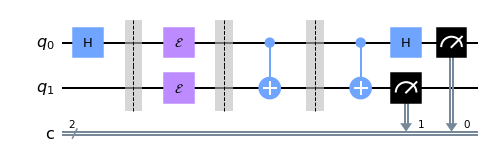

In [10]:
# meas_basis_list = ['Computational', 'Diagonal', 'Bell']
bare_experiment = create_complete_circuit(err_bell_circ, 'Bell')
bare_experiment[0].draw()

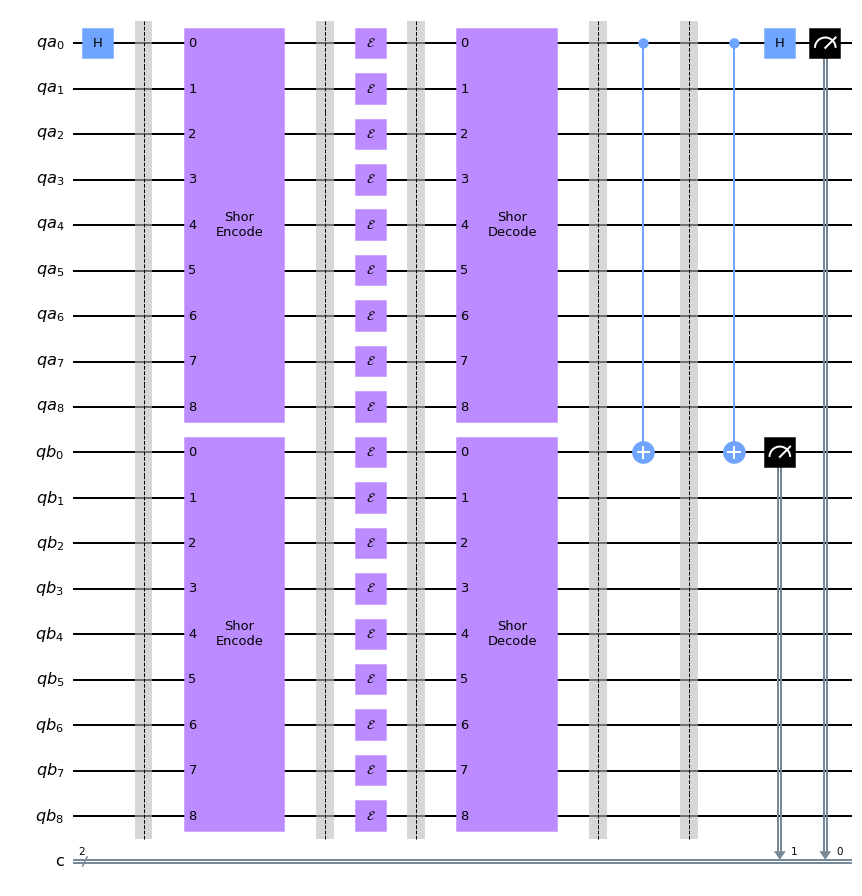

In [11]:
qa = QuantumRegister(9,'qa')
qb = QuantumRegister(9,'qb')
c = ClassicalRegister(2,'c')
encoded_bell_circ = QuantumCircuit(qa,qb,c)
num_qubits = encoded_bell_circ.num_qubits
# first part of the original circuit
encoded_bell_circ.h(0)
encoded_bell_circ.barrier()
# encoding shor code
for qlog in [qa,qb]:
    encoded_bell_circ.append(shor_encode(), qlog)
encoded_bell_circ.barrier()
# introducing error
encoded_bell_circ.unitary(E, [*qa,*qb], label='$\mathcal{E}$')
encoded_bell_circ.barrier()

# decoding shor code
for qlog in [qa,qb]:
    encoded_bell_circ.append(shor_decode(), qlog)
encoded_bell_circ.barrier()
# # rest of the original circuit
encoded_bell_circ.cx(qa[0],qb[0])
encoded_experiment = create_complete_circuit(encoded_bell_circ, 'Bell')
encoded_experiment[0].draw()

Measurement basis: Bell,
Noise: QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}]
  P(1) = 0.0475, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(2) = 0.0475, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.9025, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


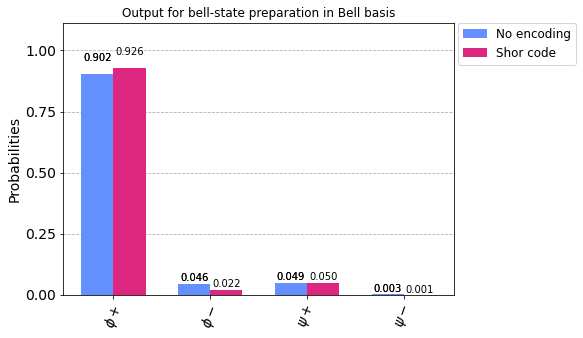

In [12]:
# executing the circuits and plotting counts
p = 0.05 # lower than threshold, Shor code is expected to do better
legend = ['No encoding', 'Shor code']
exec_and_plot([bare_experiment, encoded_experiment], bit_phase_flip(p), legend)

Measurement basis: Bell,
Noise: QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.010000000000000002, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}]
  P(1) = 0.09000000000000001, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(2) = 0.09000000000000001, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.81, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


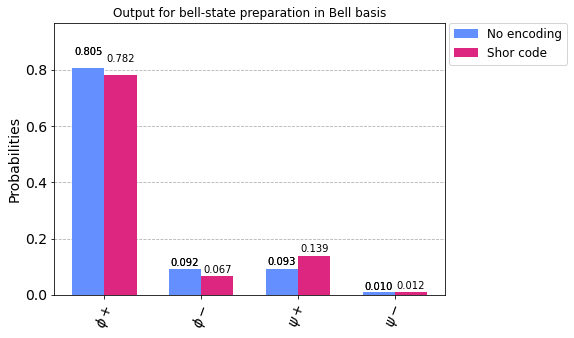

In [13]:
# executing the circuits and plotting counts
p = 0.1 # higher than threshold, hence Shor code is expected to perform worse
exec_and_plot([bare_experiment, encoded_experiment], bit_phase_flip(p), legend)

### Conclusion:
As expected, within the theoritical threshold Shor Code can correct any arbitrary unitary error. This however is not the most optimized code. The "Perfect Code" consisting of 5 qubits is the most minimal number of qubits needed to encode a qubit. However, it's not a CSS code, so there's other codes that are more popular. Particularly, Steane code which cosnists of 7 qubits is the most popular and easy to use.

## <span style="color:blue">References:</span>
- Quantum Error Correction (2013) - Daniel A. Lidar, Todd A. Brun
- Quantum Computation and Quantum Information (10th Edition) - Michael A. Neilson, Isaac L. Chuang
- Quantum Processes, Systems, and Information (2010) - Benjamin Schumacher, Michael D. Westmoreland